In [2]:
import os
from dotenv import load_dotenv
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
load_dotenv()

json_key_path = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")

if not json_key_path:
    raise ValueError("JSON key path not found. Please check the .env file.")

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = json_key_path

client = bigquery.Client()

<span style="font-size: 20px; font-weight: bold;">
1. What are the most popular events among all users during the available period (June 12, 2018 – October 3, 2018)?</span>

In [6]:
query = """
SELECT 
    event_name, 
    COUNT(*) AS event_count
FROM 
    `firebase-public-project.analytics_153293282.events_*`
WHERE 
    event_date BETWEEN '20180612' AND '20181003'
GROUP BY 
    event_name
ORDER BY 
    event_count DESC
LIMIT 10;
"""

df_1 = client.query(query).to_dataframe()

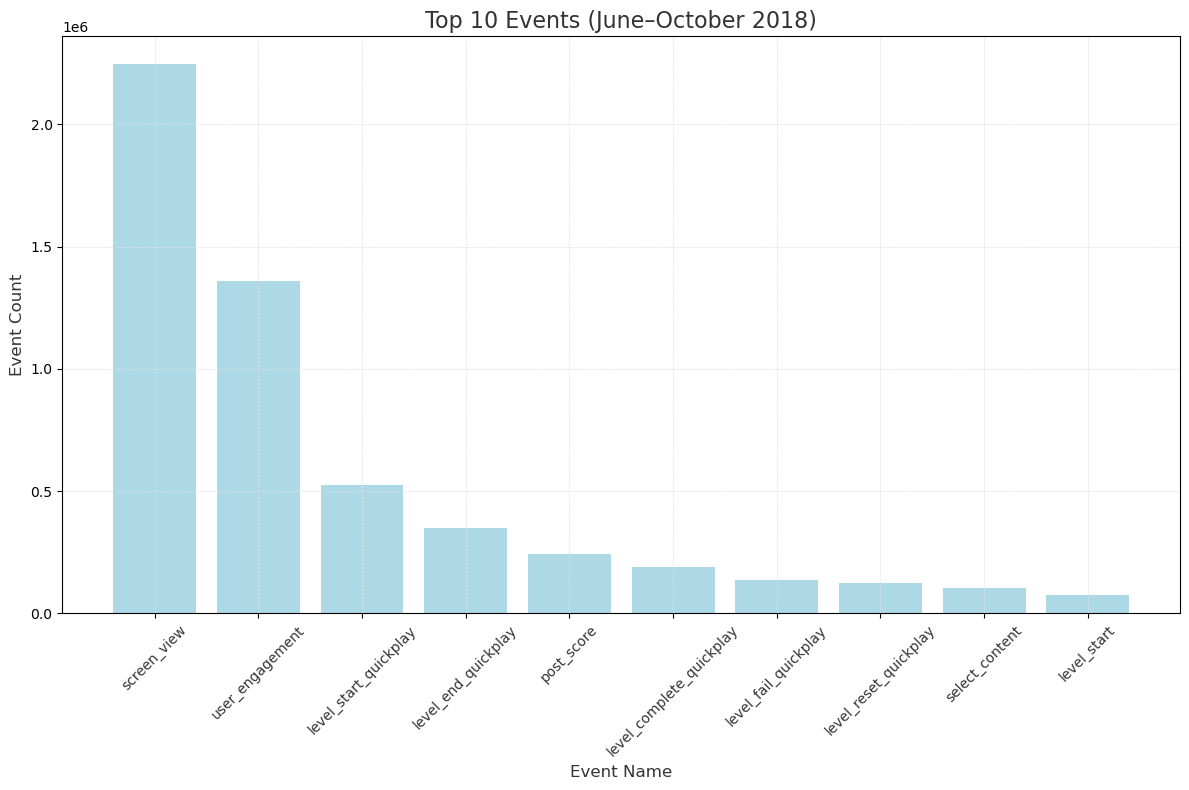

In [9]:
plt.figure(figsize=(12, 8))
plt.bar(df_1['event_name'], df_1['event_count'], color='#ADD8E6') 
plt.title("Top 10 Events (June–October 2018)", fontsize=16, color='#333333')
plt.xlabel("Event Name", fontsize=12, color='#333333') 
plt.ylabel("Event Count", fontsize=12, color='#333333')
plt.xticks(rotation=45, fontsize=10, color='#333333')
plt.grid(color='#E0E0E0', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

<span style="color: #388E3C; font-size: 16px; font-weight: bold;">
Based on the analysis, the most popular events are 
<span style="color: black; font-weight: bold;">screen_view</span> and 
<span style="color: black; font-weight: bold;">user_engagement</span>, indicating high user activity within the application. Events related to gameplay, such as 
<span style="color: black; font-weight: bold;">level_start_quickplay</span> and 
<span style="color: black; font-weight: bold;">level_end_quickplay</span>, demonstrate the popularity of the quickplay mode. Level completion outcomes, including successful completions 
(<span style="color: black; font-weight: bold;">level_complete_quickplay</span>) and failures 
(<span style="color: black; font-weight: bold;">level_fail_quickplay</span>), highlight the competitive nature of the game and its challenges. The relatively low frequency of events such as 
<span style="color: black; font-weight: bold;">level_start</span> may suggest limited use of certain functions or specific scenarios for their occurrence. Overall, the data confirms active engagement with the app’s core features but calls for additional analysis to enhance less popular events.
</span>

<span style="font-size: 20px; font-weight: bold;">
2. Which event is the most frequent continuation of other events?</span>

In [10]:
query = """
WITH transitions AS (
    SELECT
        event_name AS previous_event,
        LEAD(event_name) OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp) AS next_event
    FROM
        `firebase-public-project.analytics_153293282.events_*`
    WHERE
        event_date BETWEEN '20180612' AND '20181003'
)

SELECT
    previous_event,
    next_event,
    COUNT(*) AS transition_count
FROM
    transitions
WHERE
    next_event IS NOT NULL
GROUP BY
    previous_event, next_event
ORDER BY
    transition_count DESC
LIMIT 20;
"""

df_2 = client.query(query).to_dataframe()

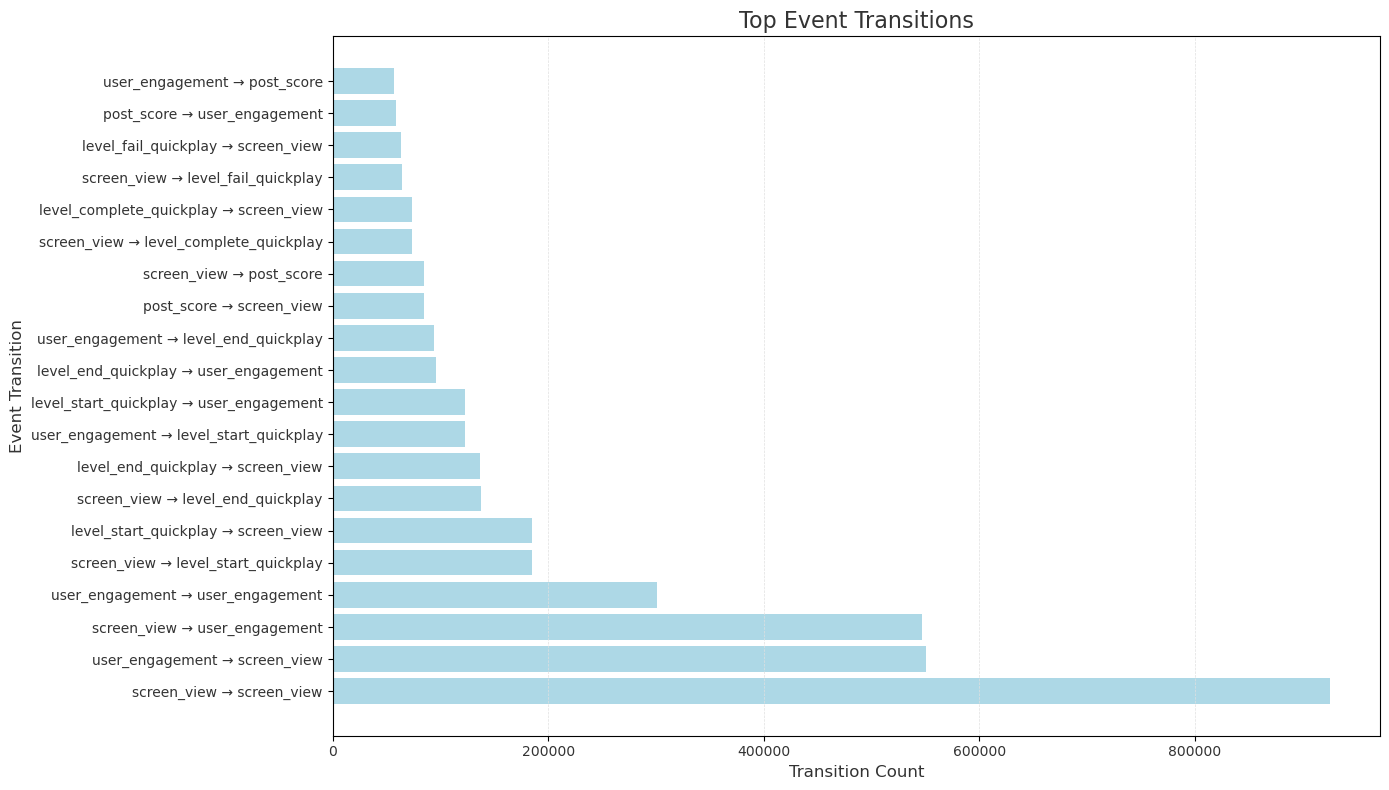

In [12]:
plt.figure(figsize=(14, 8))  
plt.barh(
    df_2['previous_event'] + " → " + df_2['next_event'],  
    df_2['transition_count'], 
    color='#ADD8E6'  
)

plt.title('Top Event Transitions', fontsize=16, color='#333333')
plt.xlabel('Transition Count', fontsize=12, color='#333333')
plt.ylabel('Event Transition', fontsize=12, color='#333333')
plt.grid(axis='x', color='#E0E0E0', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10, color='#333333')
plt.yticks(fontsize=10, color='#333333', rotation=0) 
plt.tight_layout() 
plt.show()

<span style="color: #388E3C; font-size: 16px; font-weight: bold;">
The most frequent transition in the data is 
<span style="color: black; font-weight: bold;">screen_view → screen_view</span>, showing that users often revisit or refresh screens. A large number of transitions like 
<span style="color: black; font-weight: bold;">user_engagement → screen_view</span> highlight active user interaction with the app’s main features. Game-related events such as 
<span style="color: black; font-weight: bold;">level_start_quickplay → level_end_quickplay</span> indicate a clear sequence in the quickplay mode. Less frequent transitions like 
<span style="color: black; font-weight: bold;">post_score → screen_view</span> suggest specific scenarios of usage.
</span>


<span style="color: #388E3C; font-size: 16px; font-weight: bold;">
<span style="color: black; font-size: 16px; font-weight: bold;">Recommendations:</span> Simplify navigation between screens to reduce unnecessary repetition. Explore user interactions in the quickplay mode to improve their experience. Encourage less frequent actions like 
<span style="color: black; font-weight: bold;">post_score</span> through rewards or hints. Use popular transitions to improve the app’s structure and highlight key features.
</span>

<span style="font-size: 20px; font-weight: bold;">
3. Is user activity dependent on the day of the week and the time of day?</span>

In [14]:
query = """
SELECT
    EXTRACT(DAYOFWEEK FROM TIMESTAMP_MICROS(event_timestamp)) AS day_of_week,
    EXTRACT(HOUR FROM TIMESTAMP_MICROS(event_timestamp)) AS hour,
    COUNT(*) AS event_count
FROM
    `firebase-public-project.analytics_153293282.events_*`
WHERE
    event_date BETWEEN '20180612' AND '20181003'
GROUP BY
    day_of_week, hour
ORDER BY
    day_of_week, hour;
"""

df_3 = client.query(query).to_dataframe()

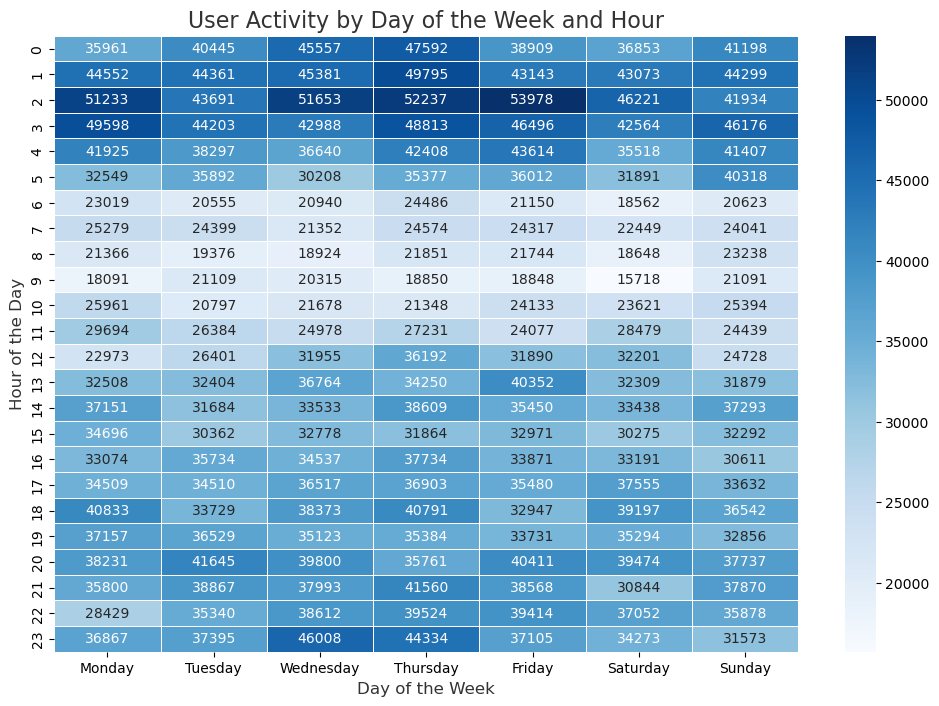

In [16]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_3['day_of_week'] = df_3['day_of_week'].apply(lambda x: days[int(x) - 1])

heatmap_data = df_3.pivot(index='hour', columns='day_of_week', values='event_count')
heatmap_data = heatmap_data[days] 
heatmap_data = heatmap_data.fillna(0).astype(int) 

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='d', linewidths=.5)  
plt.title('User Activity by Day of the Week and Hour', fontsize=16, color='#333333')
plt.xlabel('Day of the Week', fontsize=12, color='#333333')
plt.ylabel('Hour of the Day', fontsize=12, color='#333333')
plt.show()

<span style="color: #388E3C; font-size: 16px; font-weight: bold;">
The highest user activity occurs during 
<span style="color: black; font-weight: bold;">nighttime hours (particularly between 12:00 AM and 3:00 AM)</span>, which may indicate usage by audiences in different time zones or a preference among night-time users. The lowest activity is observed during daytime hours, regardless of the day of the week.
</span>


<span style="font-size: 20px; font-weight: bold;">
4. Which countries generate the largest share of events?</span>

In [18]:
query = """
SELECT
    geo.country AS country,
    COUNT(*) AS event_count
FROM
    `firebase-public-project.analytics_153293282.events_*`
WHERE
    event_date BETWEEN '20180612' AND '20181003'
GROUP BY
    country
ORDER BY
    event_count DESC
LIMIT 10;
"""

df_4 = client.query(query).to_dataframe()

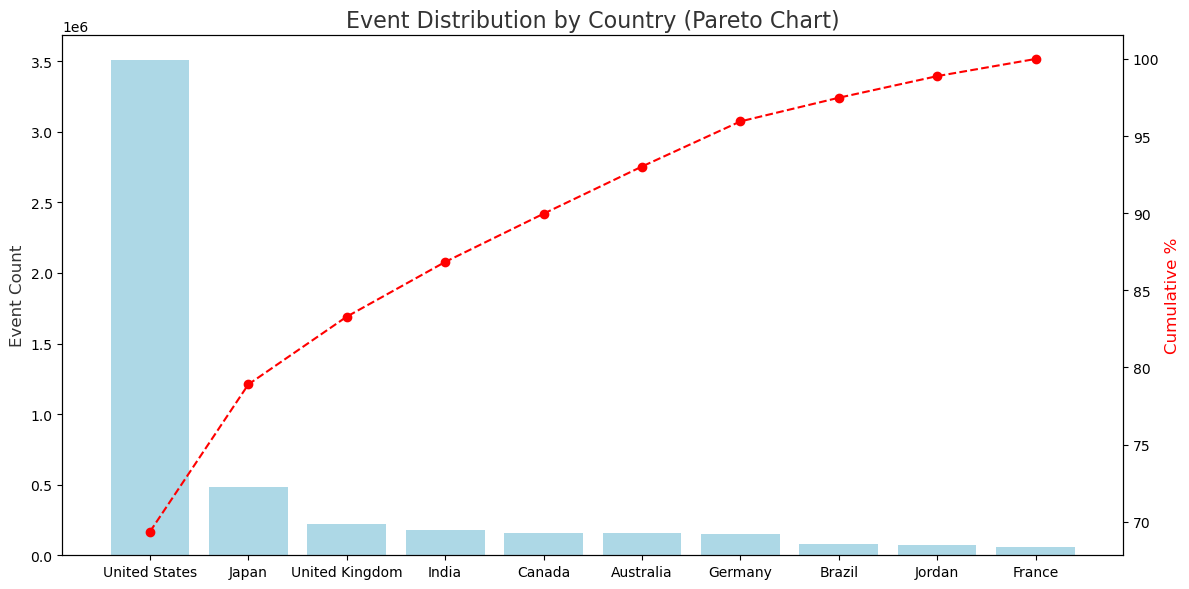

In [20]:
df_4['cumulative_percent'] = (df_4['event_count'].cumsum() / df_4['event_count'].sum()) * 100

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(df_4['country'], df_4['event_count'], color='#ADD8E6')
ax.set_ylabel('Event Count', fontsize=12, color='#333333')
ax2 = ax.twinx()
ax2.plot(df_4['country'], df_4['cumulative_percent'], color='red', marker='o', linestyle='--')
ax2.set_ylabel('Cumulative %', fontsize=12, color='red')
plt.title('Event Distribution by Country (Pareto Chart)', fontsize=16, color='#333333')
plt.xticks(rotation=45, fontsize=10, color='#333333')
plt.tight_layout()
plt.show()

<span style="color: #388E3C; font-size: 16px; font-weight: bold;">
The majority of events are generated by a small number of countries, with the <span style="color: black; font-weight: bold;">United States</span> contributing the largest share, followed by <span style="color: black; font-weight: bold;">Japan</span> and the <span style="color: black; font-weight: bold;">United Kingdom</span>. The cumulative percentage curve shows that a small group of countries accounts for a significant portion of total events, highlighting a clear concentration of activity.
</span>

<span style="font-size: 20px; font-weight: bold;">
5. What are the most popular devices and operating systems?</span>

In [22]:
query = """
SELECT
    device.category AS device_category,
    device.operating_system AS operating_system,
    COUNT(*) AS event_count
FROM
    `firebase-public-project.analytics_153293282.events_*`
WHERE
    event_date BETWEEN '20180612' AND '20181003'
GROUP BY
    device_category, operating_system
ORDER BY
    event_count DESC;
"""

df_devices = client.query(query).to_dataframe()

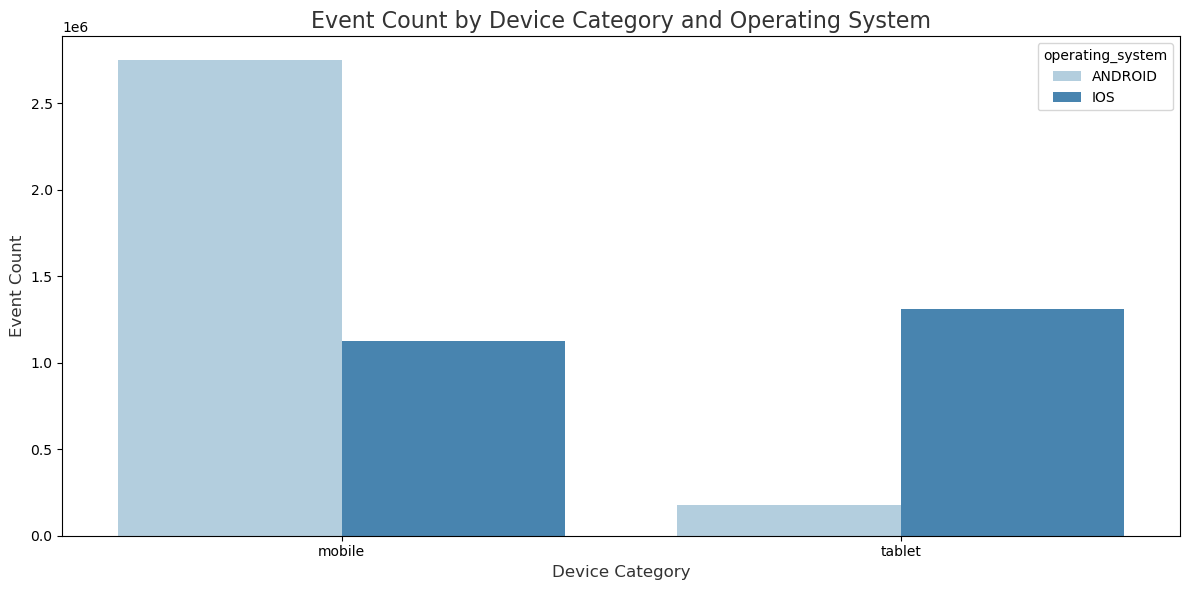

In [24]:
plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_devices, 
    x='device_category', 
    y='event_count', 
    hue='operating_system', 
    palette='Blues'
)

plt.xlabel('Device Category', fontsize=12, color='#333333')
plt.ylabel('Event Count', fontsize=12, color='#333333')
plt.title('Event Count by Device Category and Operating System', fontsize=16, color='#333333')
plt.tight_layout()
plt.show()

<span style="color: #388E3C; font-size: 16px; font-weight: bold;">
<span style="color: black; font-weight: bold;">Mobile devices</span> are the most popular category, generating the majority of events in the dataset. Among operating systems, <span style="color: black; font-weight: bold;">Android</span> dominates on mobile devices, significantly outperforming iOS. On tablets, <span style="color: black; font-weight: bold;">iOS</span> generates more events than Android, suggesting a preference for this platform in the tablet category.
</span>

<span style="font-size: 20px; font-weight: bold;">
6. What are the most common events preceding a level completion (level_complete_quickplay)?</span>

In [26]:
query = """
SELECT
    previous_event,
    COUNT(*) AS event_count
FROM (
    SELECT
        LAG(event_name) OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp) AS previous_event,
        event_name
    FROM
        `firebase-public-project.analytics_153293282.events_*`
    WHERE
        event_date BETWEEN '20180612' AND '20181003'
)
WHERE
    event_name = 'level_complete_quickplay'
GROUP BY
    previous_event
ORDER BY
    event_count DESC
LIMIT 10;
"""

df_previous_events = client.query(query).to_dataframe()

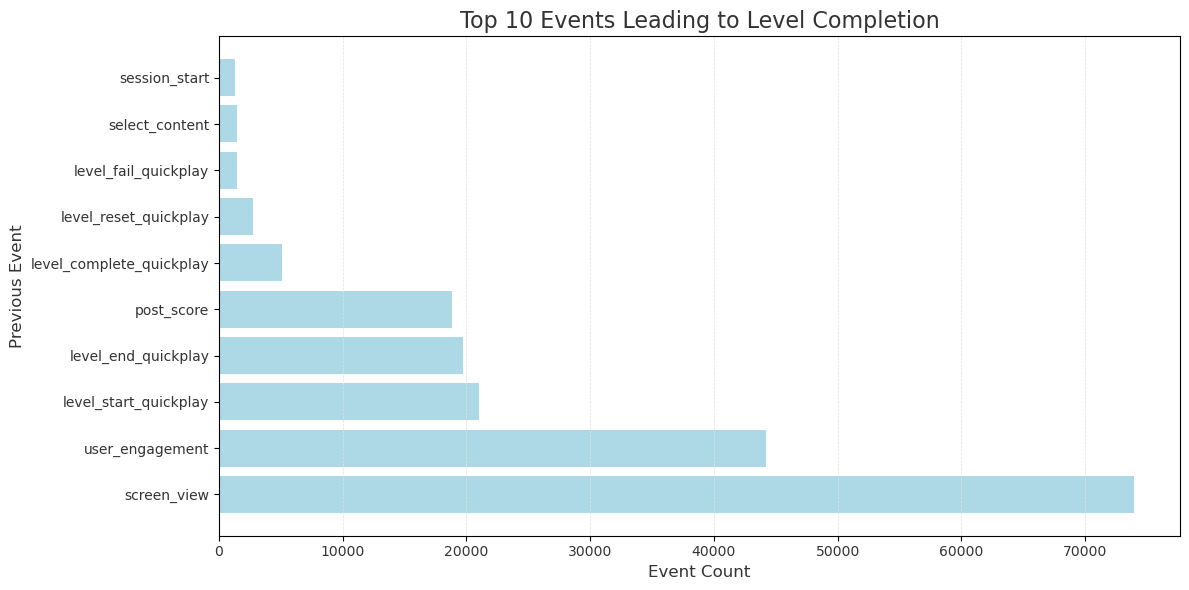

In [28]:
plt.figure(figsize=(12, 6))
plt.barh(df_previous_events['previous_event'], df_previous_events['event_count'], color='#ADD8E6')
plt.title('Top 10 Events Leading to Level Completion', fontsize=16, color='#333333')
plt.xlabel('Event Count', fontsize=12, color='#333333')
plt.ylabel('Previous Event', fontsize=12, color='#333333')
plt.xticks(fontsize=10, color='#333333')
plt.yticks(fontsize=10, color='#333333')
plt.grid(axis='x', color='#E0E0E0', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

<span style="color: #388E3C; font-size: 16px; font-weight: bold;">
<span style="color: black; font-weight: bold;">Screen view</span> and <span style="color: black; font-weight: bold;">user engagement</span> are the most common events preceding a level completion, indicating these actions are vital in guiding users to complete a level. <span style="color: black; font-weight: bold;">Level start quickplay</span> and <span style="color: black; font-weight: bold;">level end quickplay</span> suggest that most users progress systematically through the game from starting a level to completing it. Events like <span style="color: black; font-weight: bold;">post_score</span> and <span style="color: black; font-weight: bold;">level reset quickplay</span> show additional behaviors that might either support or challenge users in their gameplay experience.
</span>

<span style="font-size: 20px; font-weight: bold;">
7. Is there a relationship between the number of failed attempts (level_fail_quickplay) and successful level completions?</span>

In [30]:
query = """
SELECT
    user_pseudo_id,
    SUM(CASE WHEN event_name = 'level_fail_quickplay' THEN 1 ELSE 0 END) AS fail_count,
    SUM(CASE WHEN event_name = 'level_complete_quickplay' THEN 1 ELSE 0 END) AS completion_count
FROM
    `firebase-public-project.analytics_153293282.events_*`
WHERE
    event_date BETWEEN '20180612' AND '20181003'
GROUP BY
    user_pseudo_id;
"""

df_attempts = client.query(query).to_dataframe()

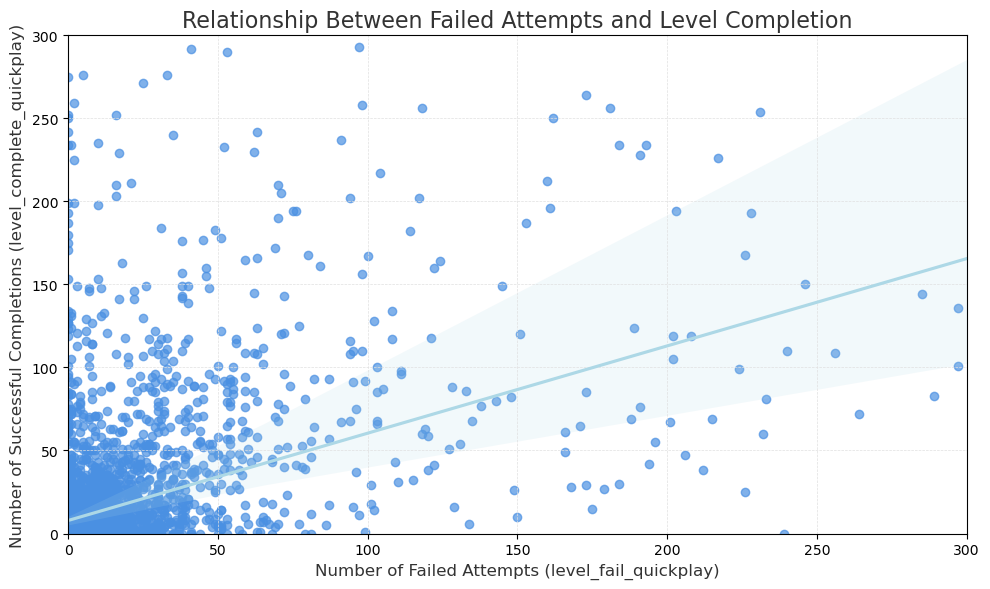

In [32]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x=df_attempts['fail_count'],
    y=df_attempts['completion_count'],
    scatter_kws={'alpha': 0.7, 'color': '#4A90E2'}, 
    line_kws={'color': '#ADD8E6'},  
)

plt.xlim(0, 300)  
plt.ylim(0, 300) 

plt.title("Relationship Between Failed Attempts and Level Completion", fontsize=16, color="#333333")
plt.xlabel("Number of Failed Attempts (level_fail_quickplay)", fontsize=12, color="#333333")
plt.ylabel("Number of Successful Completions (level_complete_quickplay)", fontsize=12, color="#333333")
plt.grid(color="#E0E0E0", linestyle="--", linewidth=0.5) 
plt.tight_layout()  
plt.show()

<span style="color: #388E3C; font-size: 16px; font-weight: bold;">
There is a <span style="color: black; font-weight: bold;">positive correlation</span> between failed attempts and successful completions. This indicates that users who fail more often are likely to eventually succeed. However, the trend suggests that most users complete levels after a relatively low number of failed attempts, while very high failure counts are rare.</span>

<span style="font-size: 20px; font-weight: bold;">
8. What is the probability of users returning to the game after a few days?</span>

In [34]:
query = """
WITH first_play_date AS (
    SELECT
        user_pseudo_id,
        MIN(PARSE_DATE('%Y%m%d', event_date)) AS first_play_date 
    FROM
        `firebase-public-project.analytics_153293282.events_*`
    GROUP BY
        user_pseudo_id
),
retention AS (
    SELECT
        e.user_pseudo_id,
        f.first_play_date,
        PARSE_DATE('%Y%m%d', e.event_date) AS event_date, 
        DATE_DIFF(PARSE_DATE('%Y%m%d', e.event_date), f.first_play_date, DAY) AS days_since_first_play
    FROM
        first_play_date f
    JOIN
        `firebase-public-project.analytics_153293282.events_*` e
    ON
        f.user_pseudo_id = e.user_pseudo_id
    WHERE
        DATE_DIFF(PARSE_DATE('%Y%m%d', e.event_date), f.first_play_date, DAY) IN (1, 3, 7)
)
SELECT
    days_since_first_play AS day,
    COUNT(DISTINCT user_pseudo_id) AS returning_users
FROM
    retention
GROUP BY
    days_since_first_play
ORDER BY
    days_since_first_play;
"""

df_retention = client.query(query).to_dataframe()

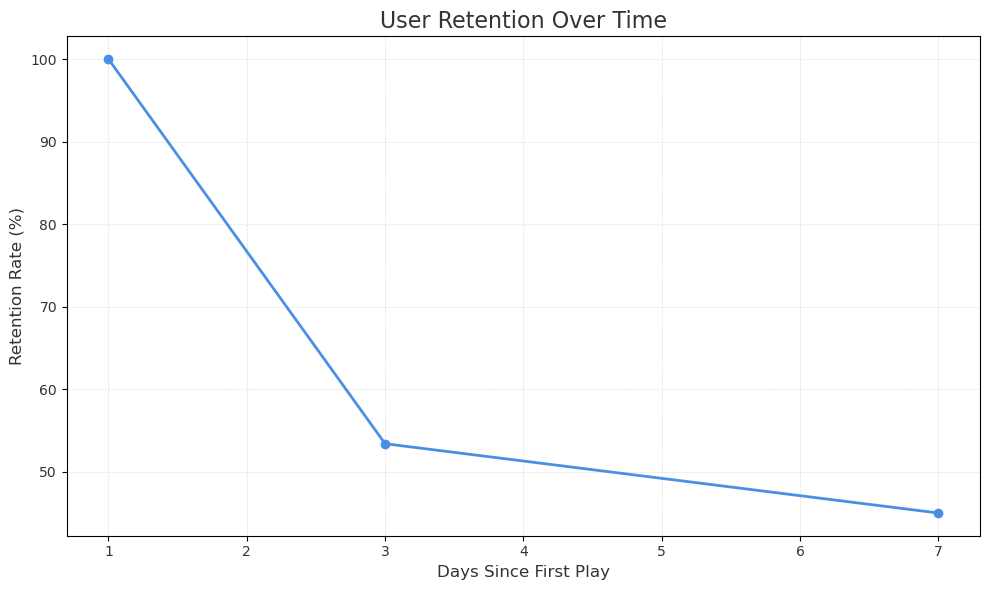

In [36]:
total_users = df_retention['returning_users'].iloc[0]

df_retention['retention_rate'] = (df_retention['returning_users'] / total_users) * 100

plt.figure(figsize=(10, 6))
plt.plot(df_retention['day'], df_retention['retention_rate'], marker='o', color='#4A90E2', linewidth=2)
plt.title('User Retention Over Time', fontsize=16, color='#333333')
plt.xlabel('Days Since First Play', fontsize=12, color='#333333')
plt.ylabel('Retention Rate (%)', fontsize=12, color='#333333')
plt.grid(color='#E0E0E0', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10, color='#333333')
plt.yticks(fontsize=10, color='#333333')
plt.tight_layout()
plt.show()

<span style="color: #388E3C; font-size: 16px; font-weight: bold;">
The retention rate drops to about 50% by the second day and decreases further to around 30% by the third day. By the seventh day, the retention is very low. This follows the common “Retention Curve,” where most users leave after the first few days, and only a small percentage continue to engage.</span>

<span style="font-size: 20px; font-weight: bold;">
9. What is the session duration with in a single day?</span> 

In [38]:
query = """
WITH session_data AS (
    SELECT
        user_pseudo_id,
        event_name,
        TIMESTAMP_MICROS(event_timestamp) AS event_time,
        LEAD(TIMESTAMP_MICROS(event_timestamp)) OVER (
            PARTITION BY user_pseudo_id
            ORDER BY event_timestamp
        ) AS next_event_time
    FROM
        `firebase-public-project.analytics_153293282.events_*`
    WHERE
        event_name IN ('session_start', 'session_end')
        AND event_date BETWEEN '20180612' AND '20181003'
)
SELECT
    user_pseudo_id,
    event_time AS session_start_time,
    next_event_time AS session_end_time,
    TIMESTAMP_DIFF(next_event_time, event_time, MINUTE) AS session_duration_minutes
FROM
    session_data
WHERE
    event_name = 'session_start'
    AND next_event_time IS NOT NULL;
"""

df_sessions = client.query(query).to_dataframe()

In [40]:
cleaned_sessions = df_sessions[
    (df_sessions['session_duration_minutes'] > 0) &
    (df_sessions['session_duration_minutes'] <= 1440)
]

mean_duration_cleaned = cleaned_sessions['session_duration_minutes'].mean()
median_duration_cleaned = cleaned_sessions['session_duration_minutes'].median()
min_duration_cleaned = cleaned_sessions['session_duration_minutes'].min()
max_duration_cleaned = cleaned_sessions['session_duration_minutes'].max()

print(f"Average session duration: {mean_duration_cleaned:.2f} minutes")
print(f"Median session duration: {median_duration_cleaned:.2f} minutes")
print(f"Shortest session duration: {min_duration_cleaned:.2f} minutes")
print(f"Longest session duration: {max_duration_cleaned:.2f} minutes")

Average session duration: 512.57 minutes
Median session duration: 351.00 minutes
Shortest session duration: 1.00 minutes
Longest session duration: 1440.00 minutes


<span style="font-size: 20px; font-weight: bold;">
10. What is the distribution of session durations for sessions lasting up to 360 minutes (6 hours)?</span> 

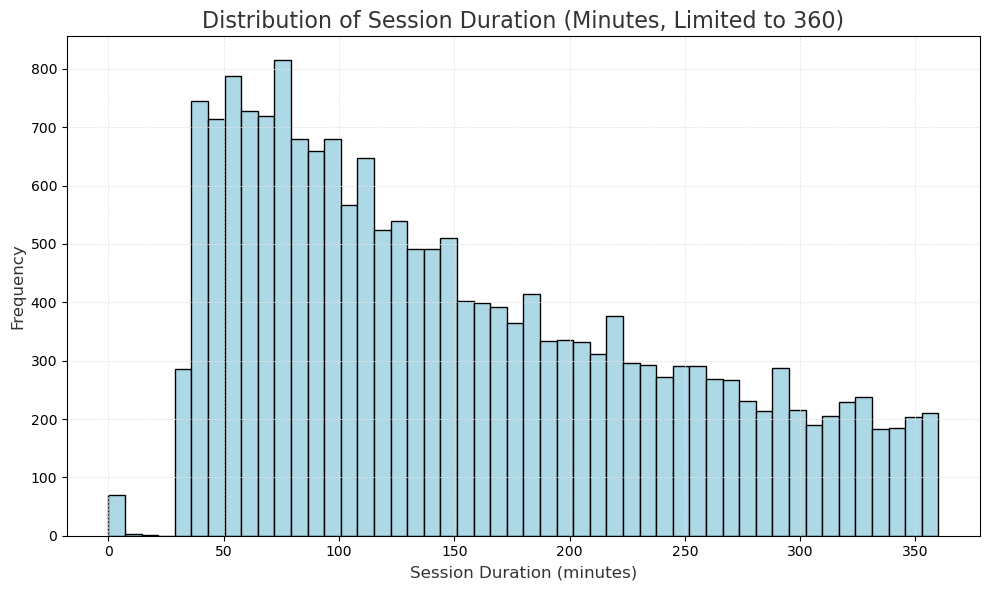

In [42]:
filtered_sessions = df_sessions[df_sessions['session_duration_minutes'] <= 360]

plt.figure(figsize=(10, 6))
plt.hist(
    filtered_sessions['session_duration_minutes'],
    bins=50, 
    color='#ADD8E6', 
    edgecolor='black'
)
plt.title('Distribution of Session Duration (Minutes, Limited to 360)', fontsize=16, color='#333333')
plt.xlabel('Session Duration (minutes)', fontsize=12, color='#333333')
plt.ylabel('Frequency', fontsize=12, color='#333333')
plt.grid(color='#E0E0E0', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

<span style="color: #388E3C; font-size: 16px; font-weight: bold;">The majority of session durations are concentrated between 50 and 150 minutes, indicating that most users engage in medium-length sessions. The frequency of sessions decreases steadily for durations longer than 150 minutes, but there is still a noticeable number of sessions extending to the limit of 360 minutes. Users appear to engage actively in sessions of moderate length, with longer sessions being less common but still significant.</span>